In [1]:
import pandas as pd
import numpy as np
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE, MeanAbsoluteError
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf 

2021-08-25 21:22:32.839032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-25 21:22:32.839074: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
#data_gemini = pd.read_csv("../data/BTCUSD_4hours.csv")

In [ ]:
#data_gemini = data_gemini.drop(columns="Unnamed: 0").set_index("date")

# Functions and Pipeline

In [ ]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011. The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
    return data

def computeRSI (data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data

def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down

def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    return data

def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [ ]:
#Feature engineering Pipeline
data = get_train_data()
add_ema(data)
add_stoch_rsi(data)
add_bollinger(data,data.log_close)
add_vol_roc(data)

In [ ]:
data_gemini = data.copy()

In [ ]:
data_gemini = data_gemini.dropna()

In [ ]:
data_gemini.head()

In [ ]:
data_gemini.drop(index=["2012-01-10 20:00:00"], axis = 0,inplace=True)

In [ ]:
data_gemini.head()

# test

In [43]:
data_gemini = pd.read_csv("../raw_data/gemini_BTCUSD_1hr.csv")


data_gemini.index
data_gemini.reset_index(inplace=True)
column_names=['Unix Timestamp','Date','Symbol','Open','High','Low','Close','Volume']
data_gemini.columns = column_names
df_gemini = data_gemini.iloc[1:].copy()

#transform to datetime
df_gemini['Date'] = pd.to_datetime(df_gemini['Date'])

#transform numerics into floats
numerics = ['Open','High','Low','Close','Volume']
for k in numerics:
    df_gemini[k] = pd.to_numeric(df_gemini[k])
    
#set date to index 
df_gemini = df_gemini.set_index('Date')

df_gemini = df_gemini.drop(columns=['Unix Timestamp', 'Symbol'])

In [44]:
data_gemini = df_gemini.resample("4H").mean()

for x in ['Open', 'High', 'Low', 'Close']:
    data_gemini[f'log_{x}'] = data_gemini[x].apply(lambda x: np.log(x))

In [45]:
data_gemini

,Open,High,Low,Close,Volume,log_Open,log_High,log_Low,log_Close
Date,,,,,,,,,
2015-10-08 12:00:00,163.333333,245.0000,163.1400,244.973333,2.692410,5.095793,5.501258,5.094609,5.501149
2015-10-08 16:00:00,244.540000,244.7250,244.0675,244.310000,3.259453,5.499379,5.500135,5.497445,5.498438
2015-10-08 20:00:00,243.975000,243.9875,243.7675,243.962500,2.659915,5.497066,5.497117,5.496215,5.497015
2015-10-09 00:00:00,243.687500,243.6875,243.6000,243.600000,0.750000,5.495887,5.495887,5.495528,5.495528
2015-10-09 04:00:00,243.600000,243.6000,243.6000,243.600000,0.000000,5.495528,5.495528,5.495528,5.495528
...,...,...,...,...,...,...,...,...,...
2021-08-12 08:00:00,45323.657500,45529.0675,44998.1425,45190.977500,69.830994,10.721584,10.726106,10.714376,10.718653
2021-08-12 12:00:00,44491.795000,44643.4775,44186.6725,44353.090000,114.602881,10.703060,10.706463,10.696178,10.699938
2021-08-12 16:00:00,44198.082500,44414.5750,44034.7175,44248.827500,84.168365,10.696437,10.701323,10.692734,10.697584


### Temporal Train-Test Split

In [46]:
train_percentage = 80

In [47]:
train_len = int(len(data_gemini) * train_percentage/100)
train_len

10251

In [48]:
data_train = data_gemini[:train_len]
data_test = data_gemini[train_len:]

In [49]:
print(data_train.shape)
print(data_test.shape)

(10251, 9)
(2563, 9)


### scaling

In [50]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [51]:
min1 = minmax_scaler.data_min_[5:9]
min1

array([5.0957931 , 5.49552754, 5.09460873, 5.49552754])

In [52]:
range1 = minmax_scaler.data_range_[5:9]
range1

array([4.79596708, 4.40131134, 4.78967689, 4.39424705])

## Basic Model

### create x and y array

In [53]:
window_size = 72 #because we want to base our prediction on 3 weeks (72*4 hours)
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size])

In [54]:
len(data_train_subsequences)

10179

In [55]:
len(fake_y_train)

10179

In [56]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,5:9]

In [57]:
print(X_train.shape)
print(y_train.shape)

(10179, 72, 9)
(10179, 4)


In [58]:
X_train

array([[[0.00000000e+00, 7.13416965e-05, 0.00000000e+00, ...,
         1.30203802e-03, 0.00000000e+00, 1.27936031e-03],
        [4.14245984e-03, 5.73281490e-05, 4.15941009e-03, ...,
         1.04686875e-03, 8.41050675e-02, 6.62314803e-04],
        [4.11363844e-03, 1.97463624e-05, 4.14399107e-03, ...,
         3.61132970e-04, 8.38482811e-02, 3.38394520e-04],
        ...,
        [5.36239573e-03, 1.38071662e-03, 5.40796552e-03, ...,
         2.39622199e-02, 1.03915284e-01, 2.37021017e-02],
        [5.42386438e-03, 1.36466474e-03, 5.35952409e-03, ...,
         2.36976740e-02, 1.03180734e-01, 2.16515433e-02],
        [5.40958121e-03, 1.40262871e-03, 5.46039020e-03, ...,
         2.43228495e-02, 1.04707333e-01, 2.43619515e-02]],

       [[4.14245984e-03, 5.73281490e-05, 4.15941009e-03, ...,
         1.04686875e-03, 8.41050675e-02, 6.62314803e-04],
        [4.11363844e-03, 1.97463624e-05, 4.14399107e-03, ...,
         3.61132970e-04, 8.38482811e-02, 3.38394520e-04],
        [4.09897269e-03, 

In [59]:
y_train

array([[0.10626838, 0.02648091, 0.10567197, 0.02545886],
       [0.10773554, 0.02791451, 0.10689503, 0.02620316],
       [0.10720565, 0.0269515 , 0.10711159, 0.02562169],
       ...,
       [0.85114795, 0.83706262, 0.85048205, 0.83640291],
       [0.8431946 , 0.8302969 , 0.84097379, 0.82790209],
       [0.84326882, 0.82861137, 0.843355  , 0.82929642]])

### Initialize a model & set layers

In [60]:
# Initialize a model, add a masking layer,LSTM,Dense Layers 
model = Sequential()
#model.add(normalizer)
#model.add(layers.Masking(mask_value=-1))
model.add(layers.LSTM(units=16, activation='tanh',input_shape = X_train[0].shape, return_sequences = True)) # first run 64 units
model.add(layers.LSTM(units=12,return_sequences = False, activation = "tanh"))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(4, activation="relu"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 72, 16)            1664      
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                1392      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
Total params: 3,230
Trainable params: 3,230
Non-trainable params: 0
_________________________________________________________________


### Compile Model 


In [61]:
# later add: es = EarlyStopping(patience=3, restore_best_weights=True)

model.compile(optimizer='rmsprop', loss="mse", metrics="mae")

### Fit Model

In [62]:
model.fit(X_train,y_train,epochs=100, batch_size=64, validation_split=0.3)

Epoch 1/100
112/112 [==============================] - 10s 73ms/step - loss: 0.0592 - mae: 0.1255 - val_loss: 3.0319e-04 - val_mae: 0.0142
Epoch 2/100
112/112 [==============================] - 8s 70ms/step - loss: 4.3195e-04 - mae: 0.0164 - val_loss: 0.0027 - val_mae: 0.0506
Epoch 3/100
112/112 [==============================] - 7s 66ms/step - loss: 3.4217e-04 - mae: 0.0151 - val_loss: 7.4904e-05 - val_mae: 0.0066
Epoch 4/100
112/112 [==============================] - 7s 66ms/step - loss: 2.8112e-04 - mae: 0.0137 - val_loss: 3.7056e-04 - val_mae: 0.0174
Epoch 5/100
112/112 [==============================] - 8s 67ms/step - loss: 2.3745e-04 - mae: 0.0124 - val_loss: 4.1350e-04 - val_mae: 0.0187
Epoch 6/100
112/112 [==============================] - 8s 68ms/step - loss: 2.1919e-04 - mae: 0.0117 - val_loss: 7.4375e-05 - val_mae: 0.0069
Epoch 7/100
112/112 [==============================] - 7s 67ms/step - loss: 1.9914e-04 - mae: 0.0113 - val_loss: 0.0013 - val_mae: 0.0335
Epoch 8/100
112/1

112/112 [==============================] - 115s 1s/step - loss: 6.0984e-05 - mae: 0.0061 - val_loss: 5.1655e-05 - val_mae: 0.0065
Epoch 59/100
112/112 [==============================] - 10s 90ms/step - loss: 6.2931e-05 - mae: 0.0062 - val_loss: 5.9642e-05 - val_mae: 0.0072
Epoch 60/100
112/112 [==============================] - 7s 67ms/step - loss: 5.9245e-05 - mae: 0.0061 - val_loss: 4.5999e-05 - val_mae: 0.0053
Epoch 61/100
112/112 [==============================] - 8s 72ms/step - loss: 6.0341e-05 - mae: 0.0062 - val_loss: 4.9981e-05 - val_mae: 0.0065
Epoch 62/100
112/112 [==============================] - 8s 73ms/step - loss: 5.8748e-05 - mae: 0.0061 - val_loss: 7.0309e-05 - val_mae: 0.0073
Epoch 63/100
112/112 [==============================] - 8s 70ms/step - loss: 5.8960e-05 - mae: 0.0062 - val_loss: 3.0121e-05 - val_mae: 0.0043
Epoch 64/100
112/112 [==============================] - 8s 68ms/step - loss: 5.5058e-05 - mae: 0.0058 - val_loss: 2.3343e-05 - val_mae: 0.0038
Epoch 65/10

## create X_test & y_test

In [63]:
#with the same window_size & horizon as the train data
window_size = 72
horizon = 1
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [64]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,5:9]

In [65]:
print(X_test.shape)
print(y_test.shape)

(2491, 72, 9)
(2491, 4)


In [66]:
y_test

array([[0.85024086, 0.83616346, 0.85139652, 0.83715705],
       [0.85047587, 0.83621155, 0.85087353, 0.83638586],
       [0.84665098, 0.83227498, 0.84608975, 0.83194026],
       ...,
       [1.16778191, 1.18278282, 1.16878968, 1.18383344],
       [1.16816964, 1.18320951, 1.16886697, 1.1840262 ],
       [1.16887779, 1.18372343, 1.1706065 , 1.18562641]])

### Predict 

In [67]:
predictions = model.predict(X_test)

In [68]:
y_pred = np.exp((predictions * range1 + min1))

In [69]:
y_pred

array([[ 9431.04614013,  9503.03258839,  9356.11279486,  9433.00429133],
       [ 9466.42694201,  9533.79118457,  9391.26824174,  9463.69535098],
       [ 9433.82340518,  9504.82523326,  9358.88842586,  9434.82535031],
       ...,
       [32801.15064374, 23811.47327622, 21288.80468276, 45044.43177642],
       [32867.84848112, 23905.6213008 , 21383.54706156, 45043.11042804],
       [32872.02042161, 23958.81141017, 21439.03762542, 44963.82975532]])

In [70]:
y_preda = predictions*range1 + min1

In [71]:
np.exp(y_preda)

array([[ 9431.04614013,  9503.03258839,  9356.11279486,  9433.00429133],
       [ 9466.42694201,  9533.79118457,  9391.26824174,  9463.69535098],
       [ 9433.82340518,  9504.82523326,  9358.88842586,  9434.82535031],
       ...,
       [32801.15064374, 23811.47327622, 21288.80468276, 45044.43177642],
       [32867.84848112, 23905.6213008 , 21383.54706156, 45043.11042804],
       [32872.02042161, 23958.81141017, 21439.03762542, 44963.82975532]])

In [72]:
y_test_unscaled = np.exp((y_test * range1 + min1))

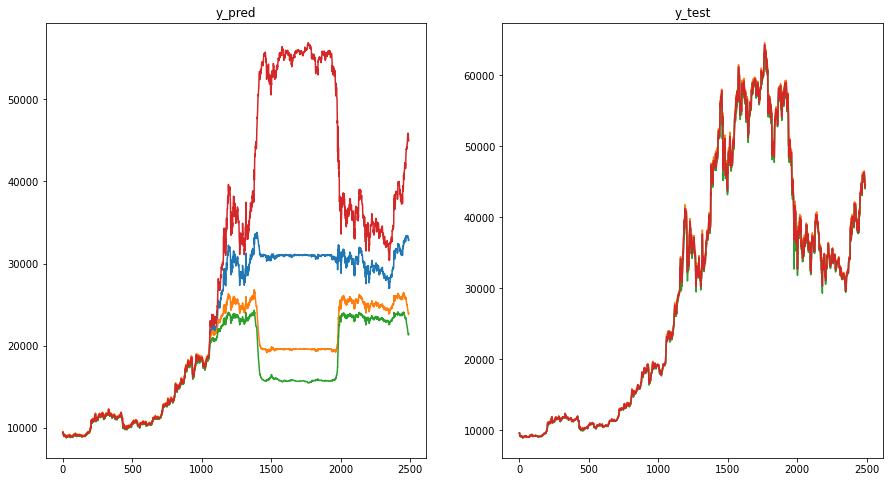

In [80]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(y_pred)
axs[0].set_title("y_pred")
axs[1].plot(y_test_unscaled)
axs[1].set_title("y_test")
plt.show()

In [73]:
len(y_pred)

2491

In [74]:
len(y_test_unscaled)

2491

In [75]:
y_test_unscaled

array([[ 9638.495 ,  9659.945 ,  9628.8875,  9645.0725],
       [ 9649.365 ,  9661.99  ,  9604.7975,  9612.4425],
       [ 9473.97  ,  9496.0275,  9387.2275,  9426.485 ],
       ...,
       [44198.0825, 44414.575 , 44034.7175, 44248.8275],
       [44280.3475, 44498.065 , 44051.0225, 44286.3225],
       [44430.99  , 44598.83  , 44419.58  , 44598.83  ]])

In [ ]:
y_pred.shape

In [ ]:
np.mean(np.abs(y_test_unscaled - y_pred))